# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Import

In [1]:
# Utilities相關函式庫
import os
import pickle
import random
from glob import glob

# 多為向量處理相關函式庫
import numpy as np

# 數據分析相關函式庫
import pandas as pd

# 圖像處理相關函式庫
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# 深度學習相關函式庫
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation 
from keras.optimizers import SGD, Adam
from keras.utils import plot_model
from sklearn.utils import shuffle

Using TensorFlow backend.


## Step 0: Load The Data
**Set related settings and parameters**

In [2]:
ROOT_DIR = os.getcwd()

DATA_DIR = os.path.join(ROOT_DIR, 'data')

# TODO: Fill this in based on where you saved the training and testing data
signnames_file = os.path.join(ROOT_DIR, 'signnames.csv')
training_file = os.path.join(DATA_DIR, 'train.p')
validation_file= os.path.join(DATA_DIR, 'valid.p')
testing_file = os.path.join(DATA_DIR, 'test.p')

**Load Data**

In [3]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
df = pd.read_csv(signnames_file)

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = df.shape[0]

id_to_labels = df.SignName

labels_to_id = {labels: i for i, labels in df.values}

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [5]:
y_train = np.eye(n_classes)[y_train]
y_valid = np.eye(n_classes)[y_valid]
y_test =np.eye(n_classes)[y_test]

### Include an exploratory visualization of the dataset

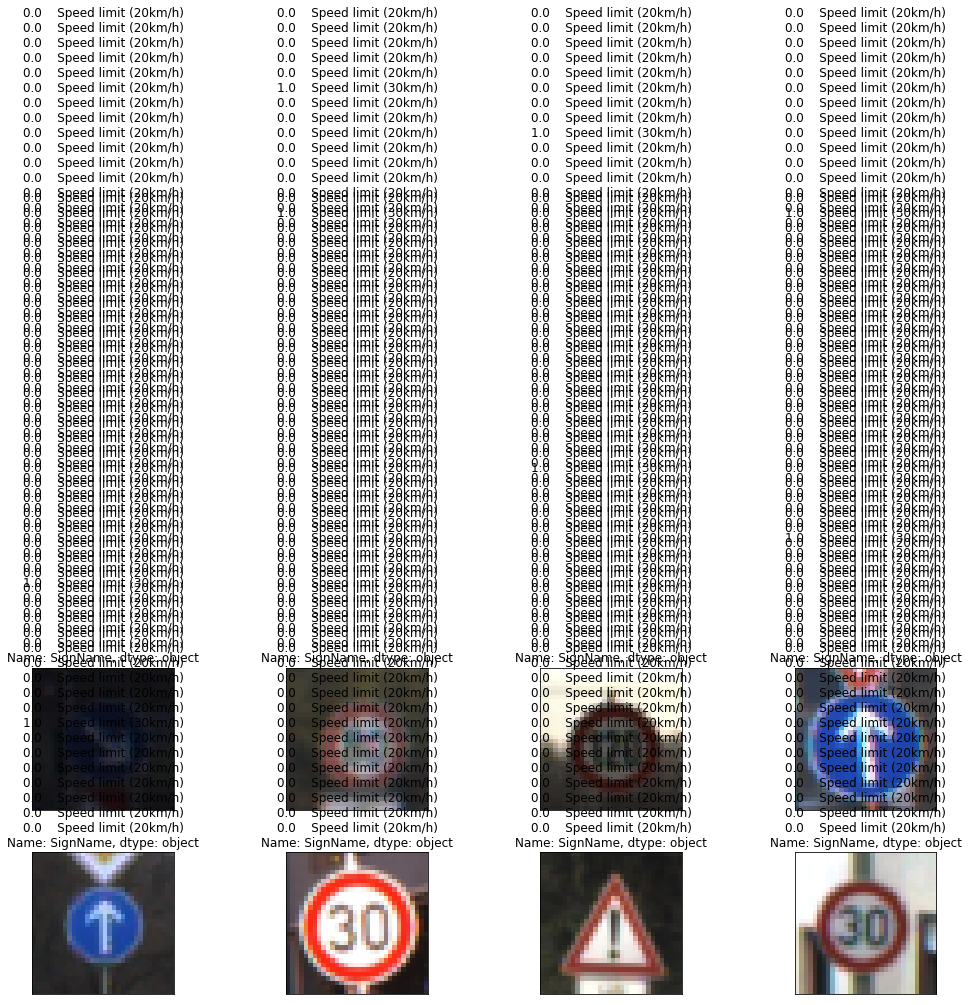

In [6]:
def images_visualize(images, labels):
    fig, axes = plt.subplots(2, 4, figsize=(18, 6), 
                             subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    for i, ax, label in zip(range(len(labels)), axes.flat, labels):
        ax.imshow(images[i])
        ax.set_title(id_to_labels[label])
    return
X_train, y_train = shuffle(X_train, y_train)
images_visualize(X_train[500:508], y_train[500:508])

----
## Step 3:Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

**noise**

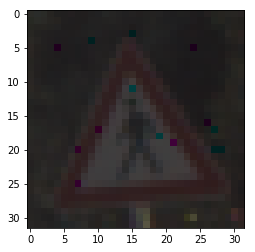

In [7]:
def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

plt.imshow(noisy(X_train[1]))

**normalization**

In [8]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
X_train = (X_train / 255.).astype('float32')
X_valid = (X_valid / 255.).astype('float32')
X_test  = (X_test  / 255.).astype('float32')

---
## Step 3: Design and Test a Model Architecture

In [9]:
x = Input(shape=(32,32,3), name='x_input')

conv1 = Conv2D(32, [3,3], strides=(1,1), padding='same', activation='relu', name='conv1')(x)
conv2 = Conv2D(32, [3,3], strides=(1,1), padding='same', activation='relu', name='conv2')(conv1)
pool1 = MaxPool2D(pool_size=(2,2), name='pool1')(conv2)

conv3 = Conv2D(64, [3,3], strides=(1,1), padding='same', activation='relu', name='conv3')(pool1)
conv4 = Conv2D(64, [3,3], strides=(1,1), padding='same', activation='relu', name='conv4')(conv3)
pool2 = MaxPool2D(pool_size=(2,2), name='pool2')(conv4)

conv5 = Conv2D(128, [3,3], strides=(1,1), padding='same', activation='relu', name='conv5')(pool2)
conv6 = Conv2D(256, [3,3], strides=(1,1), padding='same', activation='relu', name='conv6')(conv5)
pool3 = MaxPool2D(pool_size=(2,2), name='pool3')(conv6)

flat = Flatten(name='flatten')(pool3)

fc1 = Dense(512, activation='relu', name='fc1')(flat)
dropout1 = Dropout(0.5)(fc1)

fc2 = Dense(128, activation='relu', name='fc2')(dropout1)
dropout2 = Dropout(0.5)(fc2)

logits = Dense(n_classes, activation='softmax', name='fc3')(dropout2)

model = Model(inputs=x, outputs=logits)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_input (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

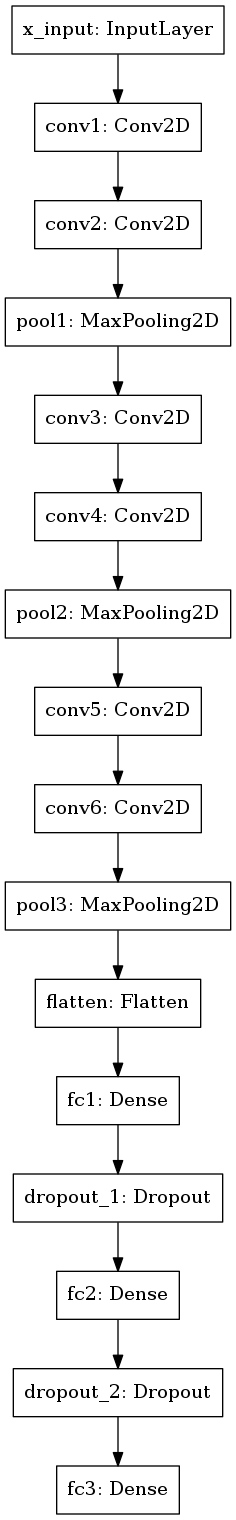

In [10]:
plot_model(model, to_file='shared_input_layer.png')
Image('shared_input_layer.png')

In [11]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

train_history = model.fit(X_train, 
                          y_train, 
                          batch_size=64, 
                          epochs=30,
                          shuffle=True,
                          validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/30
34799/34799 [==============================] - 16s 459us/step - loss: 3.2618 - acc: 0.1238 - val_loss: 2.2387 - val_acc: 0.3476
Epoch 2/30
34799/34799 [==============================] - 7s 193us/step - loss: 1.5135 - acc: 0.5117 - val_loss: 0.9938 - val_acc: 0.6737
Epoch 3/30
34799/34799 [==============================] - 8s 217us/step - loss: 0.5710 - acc: 0.8151 - val_loss: 0.3633 - val_acc: 0.9007
Epoch 4/30
34799/34799 [==============================] - 7s 202us/step - loss: 0.2583 - acc: 0.9204 - val_loss: 0.2868 - val_acc: 0.9420
Epoch 5/30
34799/34799 [==============================] - 7s 193us/step - loss: 0.1409 - acc: 0.9569 - val_loss: 0.2283 - val_acc: 0.9379
Epoch 6/30
34799/34799 [==============================] - 7s 207us/step - loss: 0.0906 - acc: 0.9732 - val_loss: 0.2941 - val_acc: 0.9488
Epoch 7/30
34799/34799 [==============================] - 7s 189us/step - loss: 0.0767 - acc: 0.9785 - val_loss: 0.3290 - 